### Data sets were acquired from https://www.kaggle.com/c/titanic

In [1]:
import warnings
warnings.filterwarnings('ignore')

##### Import datasets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mnso
from featurewiz import featurewiz
sns.set_style('darkgrid')
%matplotlib inline

df_train = pd.read_csv('train.csv', index_col=['PassengerId'])
X_test = pd.read_csv('test.csv', index_col=['PassengerId'])
X_train = df_train.drop(columns=['Survived']).copy()
y_train = df_train['Survived'].copy()
train_test = pd.concat([X_train, X_test])
test_index = X_test.index

Imported featurewiz: advanced feature engg and selection library. Version=0.0.33
output = featurewiz(dataname, target, corr_limit=0.70,
                    verbose=2, sep=',', header=0, test_data='',
                    feature_engg='', category_encoders='')
Create new features via 'feature_engg' flag : ['interactions','groupby','target']
                                


In [3]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_test = train_test.rename(columns=str.lower)

In [5]:
train_test.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<AxesSubplot:>

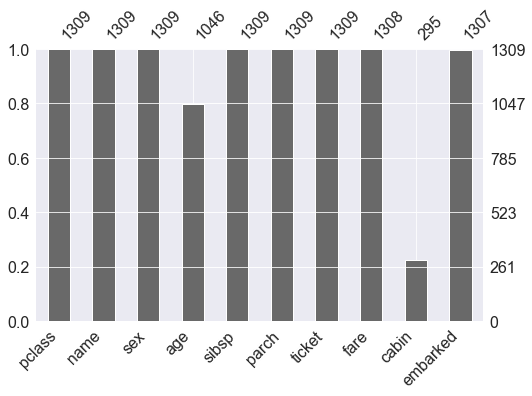

In [6]:
mnso.bar(train_test, figsize=(8, 5))

### Exploratory Data Analysis

In [7]:
# Let's find the correlation between age and other features
df_train.corr()['Age'].abs().sort_values(ascending=False)

Age         1.000000
Pclass      0.369226
SibSp       0.308247
Parch       0.189119
Fare        0.096067
Survived    0.077221
Name: Age, dtype: float64

We can see that Pclass has the strongest correlation with Age, which is a choice for imputing 'Age'

In [8]:
train_test['title'] = train_test['name'].str.extract(r'([a-zA-Z]+)\.')

In [9]:
pd.crosstab(train_test['title'], train_test['sex']).sort_values(by='title')

sex,female,male
title,,
Capt,0,1
Col,0,4
Countess,1,0
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2


In [10]:
# Convert underrepresented titles to 'Other'
train_test.title = train_test.title.replace(['Lady', 'Countess','Capt', 'Col', \
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
train_test.title = train_test.title.replace('Mlle', 'Miss')
train_test.title = train_test.title.replace('Ms', 'Miss')
train_test.title = train_test.title.replace('Mme', 'Mrs')

In [11]:
train_test['relatives'] = train_test['sibsp'] + train_test['parch']

In [12]:
train_test.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,title,relatives
PassengerId,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0


In [13]:
# Impute age
mean_age = train_test['age'].mean()
std_age = train_test['age'].std()
random_age_filled = np.random.uniform(mean_age - std_age, mean_age + std_age, size=train_test['age'].isnull().sum())
train_test.loc[train_test['age'].isna(), 'age'] = random_age_filled

#### Cleaning data

In [14]:
def remove_name(df):
    return df.drop(columns=['name', 'sibsp', 'parch', 'ticket', 'cabin', 'sex'])

def imp(df):
    df.fillna(inplace=True, value={'fare': df['fare'].median(), 'embarked': df['embarked'].mode()}) 
    return df

def encode_cat(df):
    cat_cols = df.select_dtypes(exclude='number')
    cat_cols = list(cat_cols.columns)
    df = pd.get_dummies(df, drop_first=True, columns=cat_cols)
    return df

def drop_dup(df):
    return df.drop_duplicates() 

In [15]:
from sklearn.preprocessing import StandardScaler

train_test = train_test.pipe(remove_name).pipe(imp).pipe(encode_cat)
sc = StandardScaler()
num_cols = train_test.select_dtypes(include='number').columns
train_test[num_cols] = sc.fit_transform(train_test[num_cols])

In [16]:
X_test = pd.DataFrame(train_test, index=test_index)
X_train = pd.DataFrame(train_test, index=list(set(train_test.index) - set(test_index)))

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1, stratify=y_train)

In [18]:
train_test.head()

,pclass,age,fare,relatives,embarked_Q,embarked_S,title_Miss,title_Mr,title_Mrs,title_Other
PassengerId,,,,,,,,,,
1,0.841916,-0.593240,-0.503291,0.073352,-0.32204,0.657394,-0.502625,0.853929,-0.422159,-0.15052
2,-1.546098,0.599588,0.734744,0.073352,-0.32204,-1.521159,-0.502625,-1.171058,2.368778,-0.15052
3,0.841916,-0.295033,-0.490240,-0.558346,-0.32204,0.657394,1.989556,-1.171058,-0.422159,-0.15052
4,-1.546098,0.375932,0.383183,0.073352,-0.32204,0.657394,-0.502625,-1.171058,2.368778,-0.15052
5,0.841916,0.375932,-0.487824,-0.558346,-0.32204,0.657394,-0.502625,0.853929,-0.422159,-0.15052


In [19]:
import lazypredict
from sklearn.utils.testing import ignore_warnings
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0,ignore_warnings=True)
models, predictions = clf.fit(X_train, X_val, y_train, y_val)
models[:3]

ModuleNotFoundError: No module named 'sklearn.utils.testing'

In [20]:
from tune_sklearn import TuneSearchCV
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score

def objective(trial):
    
    param = {
        'C': trial.suggest_categorical('C', np.arange(0.1, 1000, 100)),
        'gamma': trial.suggest_categorical('gamma', np.arange(0.001, 1, 100)),
        'kernel': trial.suggest_categorical('kernel', ['rbf', 'sigmoid'])}
    model = SVC(**param)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return cross_val_score(model, X_train, y_train, scoring='accuracy', n_jobs=-1, cv=StratifiedKFold(10)).mean()

In [21]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-05-02 13:14:18,378] A new study created in memory with name: no-name-5f5bfb34-2fb4-43f5-a603-5004c160205c
[I 2021-05-02 13:14:20,859] Trial 0 finished with value: 0.8247851650836726 and parameters: {'C': 700.1, 'gamma': 0.001, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.8247851650836726.
[I 2021-05-02 13:14:20,958] Trial 1 finished with value: 0.8247851650836726 and parameters: {'C': 600.1, 'gamma': 0.001, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.8247851650836726.
[I 2021-05-02 13:14:21,037] Trial 2 finished with value: 0.8262777023971054 and parameters: {'C': 300.1, 'gamma': 0.001, 'kernel': 'sigmoid'}. Best is trial 2 with value: 0.8262777023971054.
[I 2021-05-02 13:14:21,113] Trial 3 finished with value: 0.6167797376752601 and parameters: {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}. Best is trial 2 with value: 0.8262777023971054.
[I 2021-05-02 13:14:21,210] Trial 4 finished with value: 0.8247625508819538 and parameters: {'C': 300.1, 'gamma': 0.001, 'ke

Accuracy: 0.8277702397105383
Best hyperparameters: {'C': 200.1, 'gamma': 0.001, 'kernel': 'sigmoid'}


In [22]:
from yellowbrick.model_selection import learning_curve

# Build model with the best params
best = SVC(**study.best_params )

In [23]:
best.fit(X_train, y_train)
y_pred = best.predict(X_test)
y_pred = y_pred.astype(int)
y_pred = pd.DataFrame(y_pred, columns=['Survived'], index=X_test.index)
# saving the dataframe 
y_pred.to_csv('Predictions.csv') 